In [1]:
# !pip install arviz
# !pip install pymc3==3.8

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import Image
from IPython.core.pylabtools import figsize
from matplotlib import gridspec


In [3]:
df1 = pd.read_csv('preprocessed.csv',sep = ',')
df1.info()
df1['units_sold'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Columns: 123 entries, Unnamed: 0 to country__VE
dtypes: float64(12), int64(111)
memory usage: 1.5 MB


count      1573.000000
mean       4339.052765
std        9356.517210
min          10.000000
25%         100.000000
50%        1000.000000
75%        5000.000000
max      100000.000000
Name: units_sold, dtype: float64

In [4]:
#Rating Count 0.90
#Merchant Rating Count: 0.27
#Merchant pop proc :0.25
#product_color > 轉成 one hot
#product_variation_size_id > 轉成 one hot
#origin_country > 轉成 one hot

def format_data(df):
    print(df.info())
    # Targets are final grade of student
    labels = df['units_sold']
    normalized_df=( labels-labels.mean())/ labels.std()
    # print(normalized_df.head())
    # print(labels.head())
    # Drop the school and the grades from features

    tmp = df[['rating','merchant_rating_count','merch_pop_proc','price','retail_price']]

    return tmp.iloc[:1473, :], tmp.iloc[1473:, :], normalized_df.iloc[:1473], normalized_df.iloc[1473:]

In [5]:
# get train data
X_train_math,X_test_math,y_train_math, y_test_math = format_data(df1)

X_test_math.head()
#get predict data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Columns: 123 entries, Unnamed: 0 to country__VE
dtypes: float64(12), int64(111)
memory usage: 1.5 MB
None


,rating,merchant_rating_count,merch_pop_proc,price,retail_price
1473,4.67,2805,0.002139,5.00,9
1474,4.29,32318,0.005508,3.72,11
1475,3.74,139223,0.010372,3.81,59
1476,3.36,10600,0.007830,4.93,5
1477,4.05,5816,0.254298,11.00,10


In [6]:
# Set number of draws for sampling
NDRAWS = 3000
formula1 = 'y ~ ' + ' + '.join(['%s' % variable for variable in X_train_math.columns[:]])
formula2 = 'y ~ ' + ' + '.join(['%s' % variable for variable in X_train_math.columns[0:3]])
formula3 = 'y ~ ' + ' + '.join(['%s' % variable for variable in X_train_math.columns[3:]])

In [7]:
# Need to put 'y' in the data
X_train_math['y'] = list(y_train_math)
print(formula1)
print(formula2)
print(formula3)

# y_train_math

y ~ rating + merchant_rating_count + merch_pop_proc + price + retail_price
y ~ rating + merchant_rating_count + merch_pop_proc
y ~ price + retail_price


In [8]:
# Context for the model
with pm.Model() as normal_model1:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.StudentT()
    
    # Making the model only requires specifying the formula and the data
    pm.GLM.from_formula(formula1, X_train_math, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace1 = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [lam, retail_price, price, merch_pop_proc, merchant_rating_count, rating, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 4000/4000 [00:28<00:00, 139.51it/s]


In [9]:
# Context for the model
with pm.Model() as normal_model2:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.StudentT()
    
    # Making the model only requires specifying the formula and the data
    pm.GLM.from_formula(formula2, X_train_math, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace2 = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, merch_pop_proc, merchant_rating_count, rating, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 4000/4000 [00:23<00:00, 171.57it/s]


In [10]:
# Context for the model
with pm.Model() as normal_model3:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.StudentT()
    
    # Making the model only requires specifying the formula and the data
    pm.GLM.from_formula(formula3, X_train_math, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace3 = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, retail_price, price, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 360.04it/s]


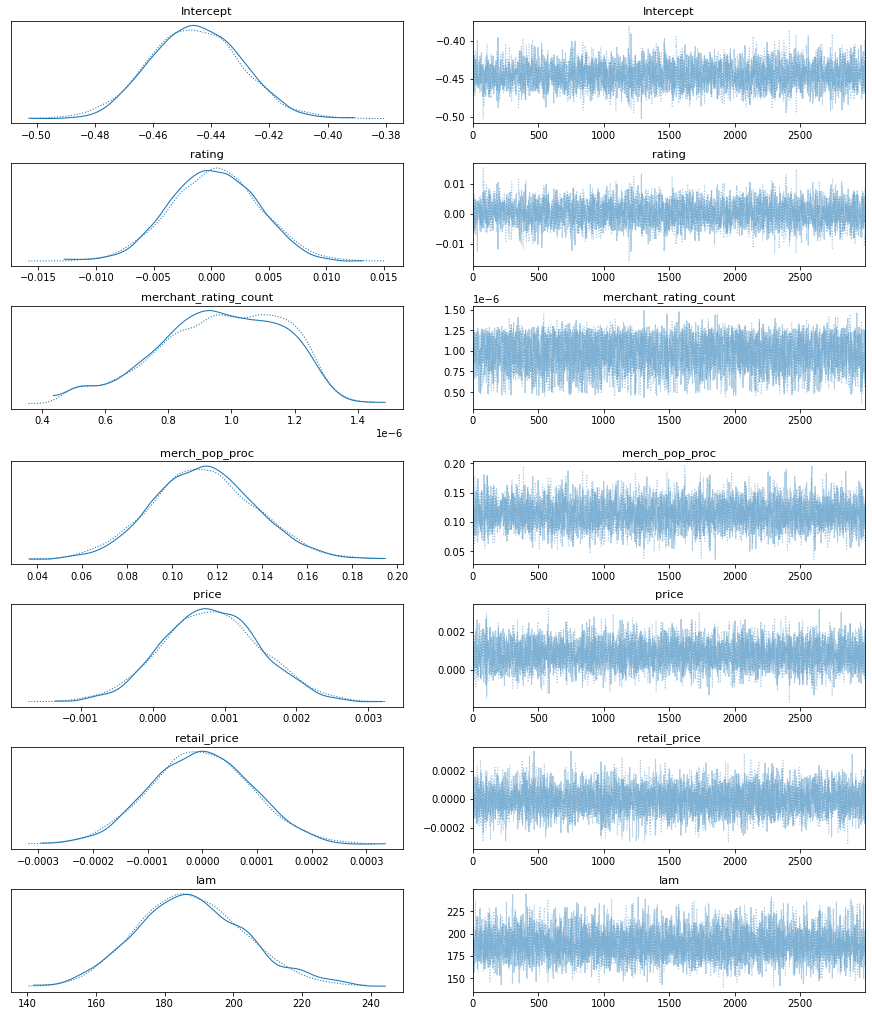

In [11]:
pm.traceplot(normal_trace1);

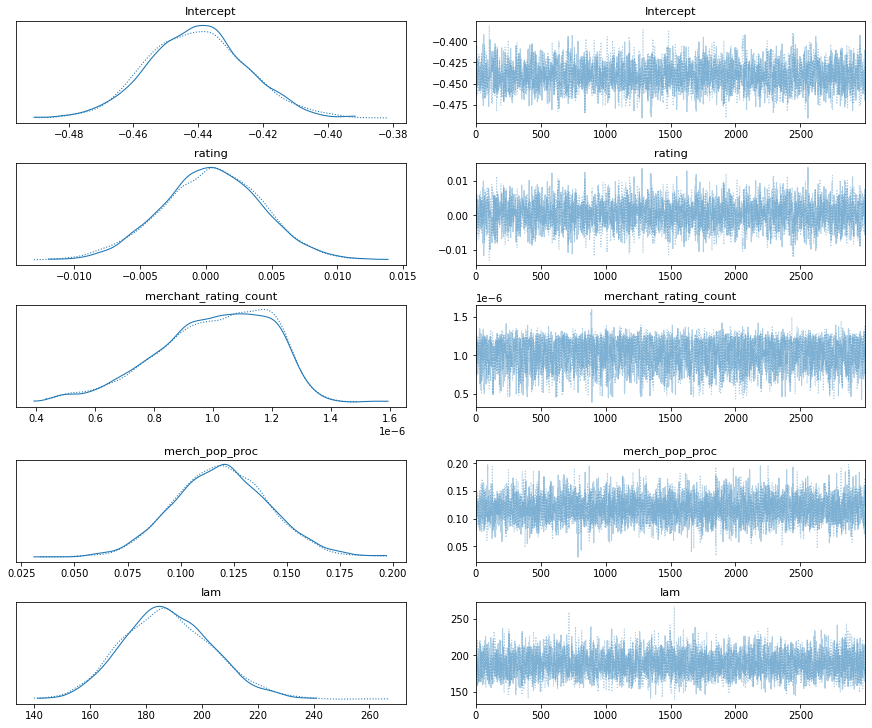

In [12]:
pm.traceplot(normal_trace2);

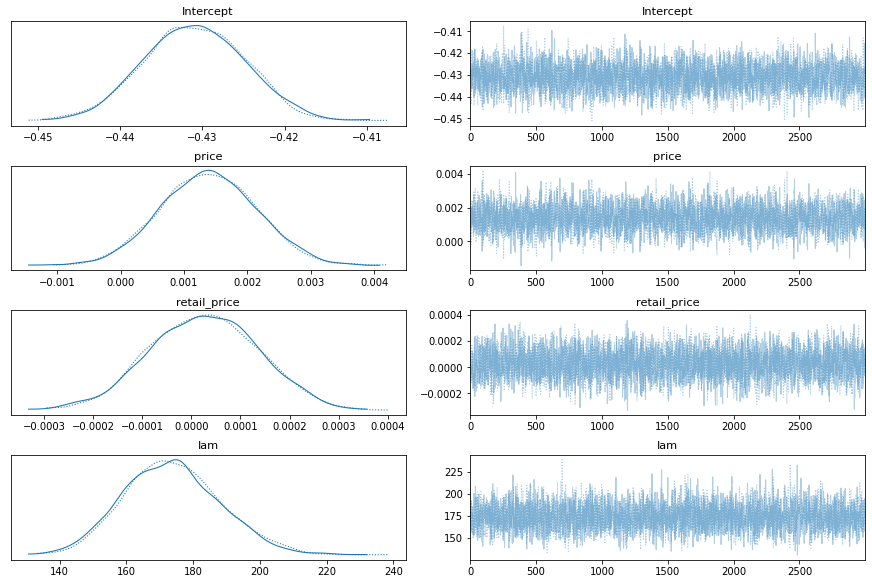

In [13]:
pm.traceplot(normal_trace3);

In [14]:
# pm.forestplot(normal_trace)

In [15]:
# pm.densityplot(normal_trace);

In [16]:
# for variable in normal_trace.varnames:
#     print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
#                                                                 np.mean(normal_trace[variable])))

In [17]:
# model_formula = 'y ~ '
# for variable in normal_trace.varnames:
#     model_formula += '(%0.4f * %s) + ' % (np.mean(normal_trace[variable]), variable)

# ' '.join(model_formula.split(' ')[:-2])

Model RMSE: 0.7551
Model MAPE: -0.0463


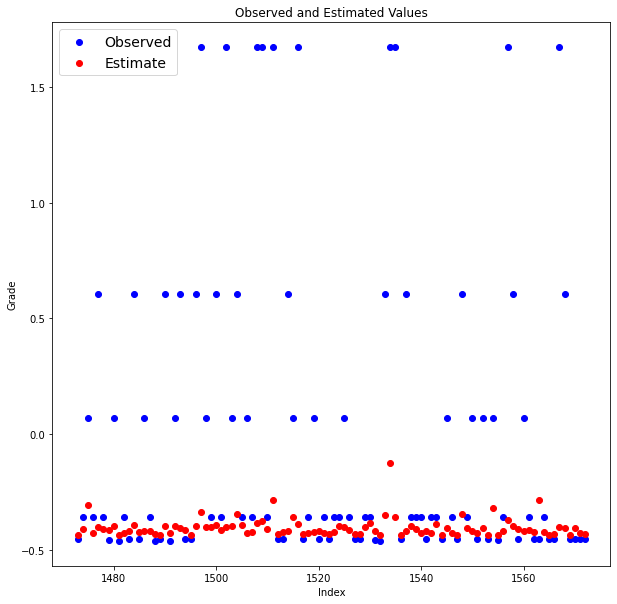

In [23]:
from sklearn.metrics import mean_squared_error
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results=None):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
    
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    rmse = np.sqrt(mean_squared_error(results['estimate'], actual))
    mape = np.median(abs(errors) / actual)
    
    print('Model RMSE: {:.4f}\nModel MAPE: {:.4f}'.format(rmse, mape))

    # Plot the observations and predictions
    figsize(10, 10)
    plt.scatter(results.index, actual, label = 'Observed', color = 'blue')
    plt.scatter(results.index, results['estimate'], label = 'Estimate', color = 'red')
    plt.legend(prop={'size': 14}); plt.xlabel('Index'); plt.ylabel('Grade');
    plt.title('Observed and Estimated Values')
    plt.show()
    
    
    return results
results = evaluate_trace(normal_trace1, X_train_math, X_test_math, y_train_math, y_test_math, None)

['Intercept', 'rating', 'merchant_rating_count', 'merch_pop_proc', 'lam_log__', 'lam']
Model RMSE: 0.7543
Model MAPE: -0.0448


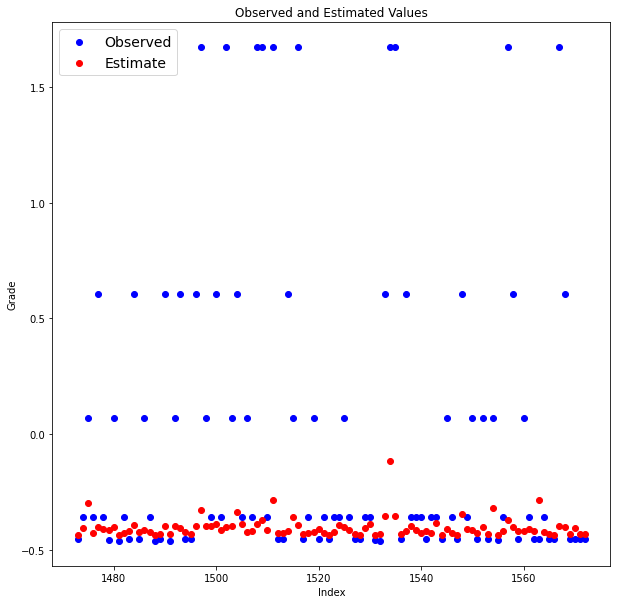

In [27]:
from sklearn.metrics import mean_squared_error
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results=None):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    print(trace.varnames)
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns.drop('price').drop('retail_price')
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
    
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    rmse = np.sqrt(mean_squared_error(results['estimate'], actual))
    mape = np.median(abs(errors) / actual)
    
    print('Model RMSE: {:.4f}\nModel MAPE: {:.4f}'.format(rmse, mape))

    # Plot the observations and predictions
    figsize(10, 10)
    plt.scatter(results.index, actual, label = 'Observed', color = 'blue')
    plt.scatter(results.index, results['estimate'], label = 'Estimate', color = 'red')
    plt.legend(prop={'size': 14}); plt.xlabel('Index'); plt.ylabel('Grade');
    plt.title('Observed and Estimated Values')
    plt.show()
    
    
    return results
results = evaluate_trace(normal_trace2, X_train_math, X_test_math, y_train_math, y_test_math, None)

['Intercept', 'price', 'retail_price', 'lam_log__', 'lam']
Model RMSE: 0.7817
Model MAPE: -0.0676


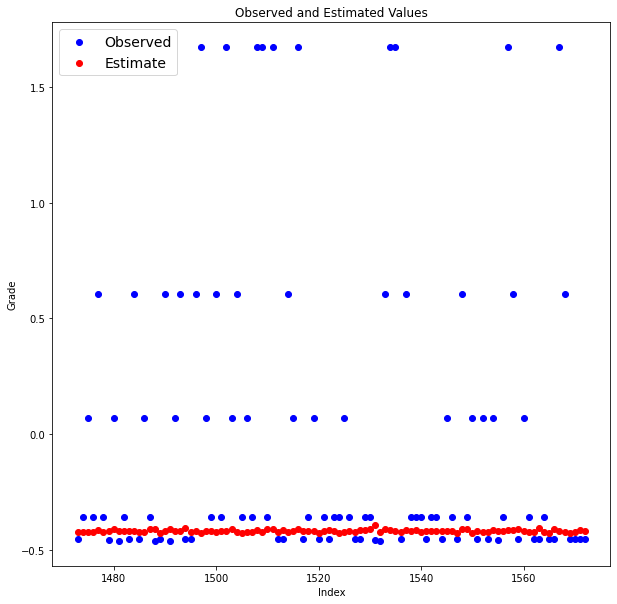

In [30]:
from sklearn.metrics import mean_squared_error
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results=None):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    print(trace.varnames)
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns.drop('rating').drop('merchant_rating_count').drop('merch_pop_proc')
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
    
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    rmse = np.sqrt(mean_squared_error(results['estimate'], actual))
    mape = np.median(abs(errors) / actual)
    
    print('Model RMSE: {:.4f}\nModel MAPE: {:.4f}'.format(rmse, mape))

    # Plot the observations and predictions
    figsize(10, 10)
    plt.scatter(results.index, actual, label = 'Observed', color = 'blue')
    plt.scatter(results.index, results['estimate'], label = 'Estimate', color = 'red')
    plt.legend(prop={'size': 14}); plt.xlabel('Index'); plt.ylabel('Grade');
    plt.title('Observed and Estimated Values')
    plt.show()
    
    
    return results
results = evaluate_trace(normal_trace3, X_train_math, X_test_math, y_train_math, y_test_math, None)

In [31]:
import arviz as az
# first_mdel_loo = az.waic(trace, first_model)
# first_waic = az.waic( trace,first_model)
LR1 = az.waic( normal_trace1,normal_model1)
LR2 = az.waic(normal_trace2,normal_model2)
LR3 = az.waic(normal_trace3,normal_model3)

df_comp_loo = az.compare({"st_LR1": normal_trace1, "st_LR2": normal_trace2,"st_LR3": normal_trace3})
df_comp_loo


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now lo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
st_LR2,0,-609.897,11.4521,0,0.752982,88.4217,0,False,log
st_LR1,1,-611.369,13.8955,1.47212,0.240719,88.4875,1.31365,False,log
st_LR3,2,-640.225,5.30074,30.3281,0.00629901,87.9778,11.6057,False,log


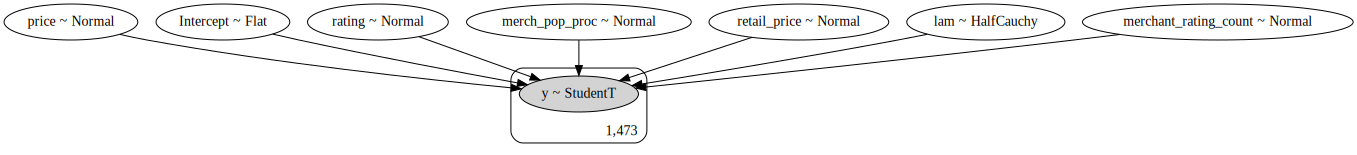

In [32]:
pm.model_to_graphviz(normal_model1)

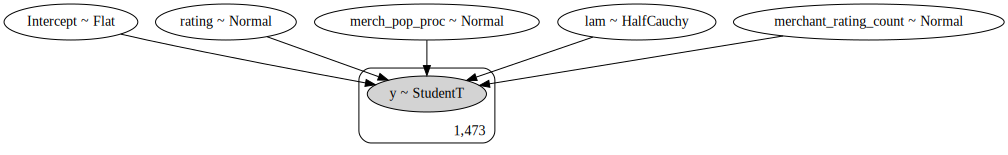

In [33]:
pm.model_to_graphviz(normal_model2)

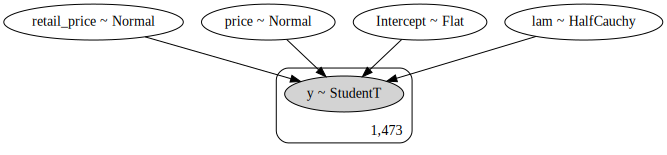

In [34]:
pm.model_to_graphviz(normal_model3)

In [40]:
formula4 = 'y ~ ' + ' + '.join(['%s' % variable for variable in X_train_math.columns[0:1]])
# Context for the model
with pm.Model() as normal_model4:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.StudentT()
    
    # Making the model only requires specifying the formula and the data
    pm.GLM.from_formula(formula4, X_train_math, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace4 = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, rating, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 241.84it/s]


In [41]:
formula5 = 'y ~ ' + ' + '.join(['%s' % variable for variable in X_train_math.columns[1:3]])
# Context for the model
with pm.Model() as normal_model5:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.StudentT()
    
    # Making the model only requires specifying the formula and the data
    pm.GLM.from_formula(formula4, X_train_math, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace5 = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, rating, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 238.47it/s]
The acceptance probability does not match the target. It is 0.8833563271038981, but should be close to 0.8. Try to increase the number of tuning steps.


In [42]:
formula6 = 'y ~ ' + ' + '.join(['%s' % variable for variable in X_train_math.columns[0:2]])
# Context for the model
with pm.Model() as normal_model6:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.StudentT()
    
    # Making the model only requires specifying the formula and the data
    pm.GLM.from_formula(formula4, X_train_math, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace6 = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, rating, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 4000/4000 [00:17<00:00, 225.60it/s]


In [43]:
formula7 = 'y ~ ' + ' + '.join(['%s' % variable for variable in [X_train_math.columns[0],X_train_math.columns[2]]])
# Context for the model
with pm.Model() as normal_model7:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.StudentT()
    
    # Making the model only requires specifying the formula and the data
    pm.GLM.from_formula(formula4, X_train_math, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace7 = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, rating, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 239.47it/s]


In [54]:
import arviz as az
# first_mdel_loo = az.waic(trace, first_model)
# first_waic = az.waic( trace,first_model)
LR4_0 = az.waic( normal_trace4,normal_model4)
LR5_12 = az.waic(normal_trace5,normal_model5)
LR6_01 = az.waic(normal_trace6,normal_model6)
LR7_02 = az.waic(normal_trace7,normal_model7)

df_comp_loo = az.compare({"LR1_012345": normal_trace1,"LR2_012": normal_trace2,"LR4_0": normal_trace4, "LR5_12": normal_trace5,"LR6_01": normal_trace6,"LR7_02": normal_trace7})
df_comp_loo


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
LR2_012,0,-609.897,11.4521,0,0.74587,89.1493,0,False,log
LR1_012345,1,-611.369,13.8955,1.47212,0.247105,89.1204,1.31365,False,log
LR7_02,2,-640.997,3.59208,31.0998,0.00187757,88.5402,11.5392,False,log
LR6_01,3,-641.042,3.62921,31.1453,0.00177823,88.5584,11.5301,False,log
LR4_0,4,-641.078,3.66394,31.1807,0.00173763,88.5729,11.5372,False,log
LR5_12,5,-641.128,3.71319,31.2307,0.00163174,88.5335,11.5339,False,log


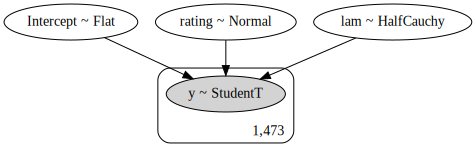

In [49]:
pm.model_to_graphviz(normal_model4)


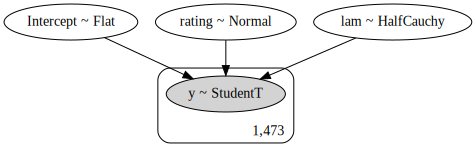

In [50]:
pm.model_to_graphviz(normal_model5)


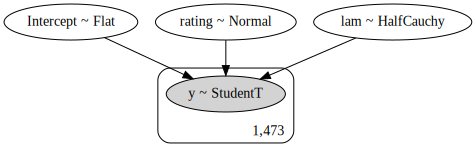

In [51]:
pm.model_to_graphviz(normal_model6)

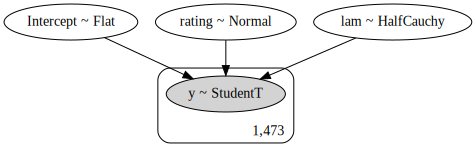

In [52]:

pm.model_to_graphviz(normal_model7)